In [1]:
"""
Created on Wed Aug 4 17:50:06 2021

@author: Amol & Dwyer
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import os
import numpy as np
from optuna_train import *
debug_mode = True  # faster experiments for debugging

def print_scientific_notation(number):
    power = int(np.log(number)/np.log(10))
    print(f"Scientific Notation: {(loss/10**power)}*10^{power}")
    
import pandas as pd
assert pd.__path__[0]!='/opt/anaconda/lib/python3.8/site-packages/pandas', 'Error! You are using deprecated pandas package outside your conda environment. Did you use Jupyter Lab again?' 
# this is a nefarious problem with current version of anaconda, root cause is conda version install your own local one!
# lightly more superficial root cause is that you sometimes use jupyter lab which triggers you to use the /opt/anaconda/bin path backup when it sees jupyter lab isn't in local environment which breaks everything (uses outdated pandas)

2022-12-16 12:31:26.683264: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer(fn='../datasets/methane_air_master.csv')
df = dp.getDataframe()

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [3]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode
exprExec.setModelFactory(PCDNNV2ModelFactory())

Parent DNNModelFactory Instantiated
Parent DNNModelFactory Instantiated


2022-12-16 12:31:29.167995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 12:31:29.546737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11079 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


## Rapid Model Testing: 
### (requires setting up PCDNNV2 for loading)

In [4]:
# fix seeds
import random
import numpy as np
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

dataType = 'randomequaltraintestsplit' #'frameworkincludedtrainexcludedtest'
inputType = 'AllSpeciesAndZmix'
dependants = 'AllDependants'
dataSetMethod = f'{inputType}_{dataType}_{dependants}'
opscaler="StandardScaler"# 'PositiveLogNormal'
ipscaler=None
ZmixPresent = 'Y'
concatenateZmix = 'Y'
kernel_constraint = 'Y'
kernel_regularizer = 'Y'
activity_regularizer = 'N'
noOfCpv = 4
noOfNeurons = 53

exprExec.modelFactory.loss='R2'
exprExec.modelFactory.activation_func='selu'
exprExec.modelFactory.dropout_rate=0.0
exprExec.debug_mode = False
exprExec.use_dependants = True
exprExec.use_dynamic_pred = True
exprExec.epochs_override = 100
exprExec.batch_size = 64
exprExec.n_models_override = 1

# initialize experiment executor...
exprExec.dm = dm
exprExec.df_experimentTracker = pd.DataFrame()
exprExec.modelType = 'PCDNNV2'

history = exprExec.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent=ZmixPresent,
                                           noOfCpv=noOfCpv,concatenateZmix=concatenateZmix,kernel_constraint=kernel_constraint,
                                           kernel_regularizer=kernel_regularizer,activity_regularizer=activity_regularizer,
                                           opscaler=opscaler, ipscaler=ipscaler)

--------------------self.build_and_compile_pcdnn_v2_model----------------------
len testing df:  9331
53 4 Y Y Y N
Model: "container_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 zmix (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 source_term_input (InputLayer)  [(None, 53)]        0           []                               
                                                                                                  
 emb_and_regression_model (Func  {'static_source_pre  351918     ['s

||                                                                                              ||
|| dropout_4 (Dropout)        (None, 512)          0           []                               ||
||                                                                                              ||
|| dense_5 (Dense)            (None, 256)          131328      []                               ||
||                                                                                              ||
|| dropout_5 (Dropout)        (None, 256)          0           []                               ||
||                                                                                              ||
|| dense_6 (Dense)            (None, 128)          32896       []                               ||
||                                                                                              ||
|| dropout_6 (Dropout)        (None, 128)          0           []                               ||
||        

/project/dwyer/home/rom_project/src/models/pcdnnv2_model_factory.py:31: UserWarning: make_output_tensor_names_consistent() is not tested for this version of tensorflow! It is tested for version 2.8.0
  warn('make_output_tensor_names_consistent() is not tested for this version of tensorflow! It is tested for version 2.8.0')


53 4 Y Y Y N
training model: 1
Epoch 1/100


/project/dwyer/home/rom_project/src/models/pcdnnv2_model_factory.py:31: UserWarning: make_output_tensor_names_consistent() is not tested for this version of tensorflow! It is tested for version 2.8.0
  warn('make_output_tensor_names_consistent() is not tested for this version of tensorflow! It is tested for version 2.8.0')


Cause: could not parse the source code of <function PCDNNV2ModelFactory.build_and_compile_model.<locals>.<lambda> at 0x7f88905349d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda yt, yp: -R2(yt, yp)

Match 1:
lambda yt, yp: -R2_split(yt, yp)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function PCDNNV2ModelFactory.build_and_compile_model.<locals>.<lambda> at 0x7f88905349d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names. The matching definitions were:
Match 0:
lambda yt, yp: -R2(yt, yp)

Match 1:
lambda yt, yp: -R2_split(yt, yp)

To silence this warning, decorate the function with @tf.autograph.experimental

Epoch 7/100
73/73 [==============================] - 1s 19ms/step - loss: 144.9901 - dynamic_source_prediction_loss: 22.3873 - static_source_prediction_loss: 121.4141 - dynamic_source_prediction_R2_split: -22.3729 - dynamic_source_prediction_source_pred_mean: -15.5652 - dynamic_source_prediction_source_true_mean: -97.0825 - static_source_prediction_mae: 1.4299 - static_source_prediction_mse: 5.0106 - static_source_prediction_R2: -121.2368 - static_source_prediction_mape: 1042.5310 - val_loss: 36.0162 - val_dynamic_source_prediction_loss: 12.4092 - val_static_source_prediction_loss: 22.4544 - val_dynamic_source_prediction_R2_split: -12.4082 - val_dynamic_source_prediction_source_pred_mean: -18.5914 - val_dynamic_source_prediction_source_true_mean: -89.3609 - val_static_source_prediction_mae: 1.0329 - val_static_source_prediction_mse: 2.5007 - val_static_source_prediction_R2: -22.4281 - val_static_source_prediction_mape: 629.7998
Epoch 8/100
73/73 [==============================] - 1s 19

Epoch 16/100
73/73 [==============================] - 1s 19ms/step - loss: 449.0186 - dynamic_source_prediction_loss: 1.0619 - static_source_prediction_loss: 447.3184 - dynamic_source_prediction_R2_split: -1.0614 - dynamic_source_prediction_source_pred_mean: -27.8207 - dynamic_source_prediction_source_true_mean: -27.3047 - static_source_prediction_mae: 0.6287 - static_source_prediction_mse: 1.0807 - static_source_prediction_R2: -446.6493 - static_source_prediction_mape: 261.7048 - val_loss: 6.9751 - val_dynamic_source_prediction_loss: 1.0161 - val_static_source_prediction_loss: 5.3438 - val_dynamic_source_prediction_R2_split: -1.0160 - val_dynamic_source_prediction_source_pred_mean: -24.7465 - val_dynamic_source_prediction_source_true_mean: -24.6405 - val_static_source_prediction_mae: 0.6391 - val_static_source_prediction_mse: 1.1923 - val_static_source_prediction_R2: -5.3373 - val_static_source_prediction_mape: 269.4952
Epoch 17/100
73/73 [==============================] - 1s 19ms/ste

Epoch 25/100
73/73 [==============================] - 1s 19ms/step - loss: 1039.9567 - dynamic_source_prediction_loss: 0.3699 - static_source_prediction_loss: 1039.1765 - dynamic_source_prediction_R2_split: -0.3699 - dynamic_source_prediction_source_pred_mean: -19.1068 - dynamic_source_prediction_source_true_mean: -1.1580 - static_source_prediction_mae: 0.5606 - static_source_prediction_mse: 0.9742 - static_source_prediction_R2: -1037.6216 - static_source_prediction_mape: 201.9830 - val_loss: 5.0081 - val_dynamic_source_prediction_loss: 0.3541 - val_static_source_prediction_loss: 4.2522 - val_dynamic_source_prediction_R2_split: -0.3541 - val_dynamic_source_prediction_source_pred_mean: -17.8931 - val_dynamic_source_prediction_source_true_mean: -1.9095 - val_static_source_prediction_mae: 0.5703 - val_static_source_prediction_mse: 1.0986 - val_static_source_prediction_R2: -4.2471 - val_static_source_prediction_mape: 229.8303
Epoch 26/100
73/73 [==============================] - 1s 19ms/st

Epoch 34/100
73/73 [==============================] - 1s 19ms/step - loss: 7.4930 - dynamic_source_prediction_loss: 0.2032 - static_source_prediction_loss: 6.9689 - dynamic_source_prediction_R2_split: -0.2031 - dynamic_source_prediction_source_pred_mean: -9.4551 - dynamic_source_prediction_source_true_mean: -0.6177 - static_source_prediction_mae: 0.5119 - static_source_prediction_mse: 0.9036 - static_source_prediction_R2: -6.9590 - static_source_prediction_mape: 169.8222 - val_loss: 1.4123 - val_dynamic_source_prediction_loss: 0.2041 - val_static_source_prediction_loss: 0.8915 - val_dynamic_source_prediction_R2_split: -0.2041 - val_dynamic_source_prediction_source_pred_mean: -9.0297 - val_dynamic_source_prediction_source_true_mean: -1.2724 - val_static_source_prediction_mae: 0.5123 - val_static_source_prediction_mse: 1.0334 - val_static_source_prediction_R2: -0.8904 - val_static_source_prediction_mape: 168.2379
Epoch 35/100
73/73 [==============================] - 1s 19ms/step - loss: 

Epoch 43/100
73/73 [==============================] - 1s 19ms/step - loss: 0.8466 - dynamic_source_prediction_loss: 0.0887 - static_source_prediction_loss: 0.4950 - dynamic_source_prediction_R2_split: -0.0885 - dynamic_source_prediction_source_pred_mean: -7.7136 - dynamic_source_prediction_source_true_mean: -0.6047 - static_source_prediction_mae: 0.4700 - static_source_prediction_mse: 0.8520 - static_source_prediction_R2: -0.4942 - static_source_prediction_mape: 151.0822 - val_loss: 0.7267 - val_dynamic_source_prediction_loss: 0.0848 - val_static_source_prediction_loss: 0.3807 - val_dynamic_source_prediction_R2_split: -0.0848 - val_dynamic_source_prediction_source_pred_mean: -7.4932 - val_dynamic_source_prediction_source_true_mean: -1.0538 - val_static_source_prediction_mae: 0.4762 - val_static_source_prediction_mse: 0.9821 - val_static_source_prediction_R2: -0.3802 - val_static_source_prediction_mape: 144.5065
Epoch 44/100
73/73 [==============================] - 1s 19ms/step - loss: 

Epoch 52/100
73/73 [==============================] - 1s 19ms/step - loss: 3.9631 - dynamic_source_prediction_loss: 0.0258 - static_source_prediction_loss: 3.7076 - dynamic_source_prediction_R2_split: -0.0257 - dynamic_source_prediction_source_pred_mean: -6.3716 - dynamic_source_prediction_source_true_mean: -0.0480 - static_source_prediction_mae: 0.4420 - static_source_prediction_mse: 0.8129 - static_source_prediction_R2: -3.7028 - static_source_prediction_mape: 135.2509 - val_loss: 0.6359 - val_dynamic_source_prediction_loss: 0.0064 - val_static_source_prediction_loss: 0.4016 - val_dynamic_source_prediction_R2_split: -0.0064 - val_dynamic_source_prediction_source_pred_mean: -6.7490 - val_dynamic_source_prediction_source_true_mean: -0.5597 - val_static_source_prediction_mae: 0.4496 - val_static_source_prediction_mse: 0.9537 - val_static_source_prediction_R2: -0.4010 - val_static_source_prediction_mape: 135.8016
Epoch 53/100
73/73 [==============================] - 1s 19ms/step - loss: 

Epoch 61/100
73/73 [==============================] - 1s 19ms/step - loss: 1.3766 - dynamic_source_prediction_loss: -0.0376 - static_source_prediction_loss: 1.2099 - dynamic_source_prediction_R2_split: 0.0379 - dynamic_source_prediction_source_pred_mean: -6.3766 - dynamic_source_prediction_source_true_mean: -0.3525 - static_source_prediction_mae: 0.4130 - static_source_prediction_mse: 0.7783 - static_source_prediction_R2: -1.2079 - static_source_prediction_mape: 139.9872 - val_loss: 0.3268 - val_dynamic_source_prediction_loss: -0.0461 - val_static_source_prediction_loss: 0.1700 - val_dynamic_source_prediction_R2_split: 0.0460 - val_dynamic_source_prediction_source_pred_mean: -6.2555 - val_dynamic_source_prediction_source_true_mean: -0.5914 - val_static_source_prediction_mae: 0.4201 - val_static_source_prediction_mse: 0.9086 - val_static_source_prediction_R2: -0.1696 - val_static_source_prediction_mape: 126.3615
Epoch 62/100
73/73 [==============================] - 1s 19ms/step - loss: 

Epoch 70/100
73/73 [==============================] - 1s 19ms/step - loss: 1.2439 - dynamic_source_prediction_loss: -0.0673 - static_source_prediction_loss: 1.1315 - dynamic_source_prediction_R2_split: 0.0676 - dynamic_source_prediction_source_pred_mean: -6.3986 - dynamic_source_prediction_source_true_mean: -0.2741 - static_source_prediction_mae: 0.4022 - static_source_prediction_mse: 0.7578 - static_source_prediction_R2: -1.1296 - static_source_prediction_mape: 126.5931 - val_loss: 0.5838 - val_dynamic_source_prediction_loss: -0.0786 - val_static_source_prediction_loss: 0.4840 - val_dynamic_source_prediction_R2_split: 0.0785 - val_dynamic_source_prediction_source_pred_mean: -5.9616 - val_dynamic_source_prediction_source_true_mean: -0.3767 - val_static_source_prediction_mae: 0.4029 - val_static_source_prediction_mse: 0.8878 - val_static_source_prediction_R2: -0.4832 - val_static_source_prediction_mape: 127.9634
Epoch 71/100
73/73 [==============================] - 1s 19ms/step - loss: 

Epoch 79/100
73/73 [==============================] - 1s 19ms/step - loss: 9.2573 - dynamic_source_prediction_loss: -0.1023 - static_source_prediction_loss: 9.2010 - dynamic_source_prediction_R2_split: 0.1023 - dynamic_source_prediction_source_pred_mean: -6.4045 - dynamic_source_prediction_source_true_mean: -0.2078 - static_source_prediction_mae: 0.3955 - static_source_prediction_mse: 0.7459 - static_source_prediction_R2: -9.2001 - static_source_prediction_mape: 130.1746 - val_loss: 0.0689 - val_dynamic_source_prediction_loss: -0.1141 - val_static_source_prediction_loss: 0.0259 - val_dynamic_source_prediction_R2_split: 0.1139 - val_dynamic_source_prediction_source_pred_mean: -6.4628 - val_dynamic_source_prediction_source_true_mean: -0.3510 - val_static_source_prediction_mae: 0.3886 - val_static_source_prediction_mse: 0.8658 - val_static_source_prediction_R2: -0.0256 - val_static_source_prediction_mape: 125.0614
Epoch 80/100
73/73 [==============================] - 1s 19ms/step - loss: 

Epoch 88/100
73/73 [==============================] - 1s 19ms/step - loss: 2.8241 - dynamic_source_prediction_loss: -0.1085 - static_source_prediction_loss: 2.7933 - dynamic_source_prediction_R2_split: 0.1083 - dynamic_source_prediction_source_pred_mean: -5.7950 - dynamic_source_prediction_source_true_mean: -0.2009 - static_source_prediction_mae: 0.3799 - static_source_prediction_mse: 0.7212 - static_source_prediction_R2: -2.7893 - static_source_prediction_mape: 144.1049 - val_loss: 0.2107 - val_dynamic_source_prediction_loss: -0.1120 - val_static_source_prediction_loss: 0.1845 - val_dynamic_source_prediction_R2_split: 0.1118 - val_dynamic_source_prediction_source_pred_mean: -5.2665 - val_dynamic_source_prediction_source_true_mean: -0.2169 - val_static_source_prediction_mae: 0.3878 - val_static_source_prediction_mse: 0.8479 - val_static_source_prediction_R2: -0.1840 - val_static_source_prediction_mape: 144.5415
Epoch 89/100
73/73 [==============================] - 1s 19ms/step - loss: 

Epoch 97/100
73/73 [==============================] - 1s 19ms/step - loss: 3.0023 - dynamic_source_prediction_loss: -0.1416 - static_source_prediction_loss: 3.0215 - dynamic_source_prediction_R2_split: 0.1417 - dynamic_source_prediction_source_pred_mean: -5.8449 - dynamic_source_prediction_source_true_mean: -0.3609 - static_source_prediction_mae: 0.3726 - static_source_prediction_mse: 0.7007 - static_source_prediction_R2: -3.0200 - static_source_prediction_mape: 135.4905 - val_loss: 0.4402 - val_dynamic_source_prediction_loss: -0.1373 - val_static_source_prediction_loss: 0.4555 - val_dynamic_source_prediction_R2_split: 0.1371 - val_dynamic_source_prediction_source_pred_mean: -5.1321 - val_dynamic_source_prediction_source_true_mean: -0.3122 - val_static_source_prediction_mae: 0.3749 - val_static_source_prediction_mse: 0.8283 - val_static_source_prediction_R2: -0.4546 - val_static_source_prediction_mape: 149.4684
Epoch 98/100
73/73 [==============================] - 1s 19ms/step - loss: 

/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


                TAE           TSE  TRE           MAE           MSE  MRE  MAPE  \
count  1.000000e+00  1.000000e+00  1.0  1.000000e+00  1.000000e+00  1.0   1.0   
mean   1.393591e+14  1.209925e+25  inf  1.493507e+10  1.296672e+21  inf   inf   
std             NaN           NaN  NaN           NaN           NaN  NaN   NaN   
min    1.393591e+14  1.209925e+25  inf  1.493507e+10  1.296672e+21  inf   inf   
25%    1.393591e+14  1.209925e+25  NaN  1.493507e+10  1.296672e+21  NaN   NaN   
50%    1.393591e+14  1.209925e+25  NaN  1.493507e+10  1.296672e+21  NaN   NaN   
75%    1.393591e+14  1.209925e+25  NaN  1.493507e+10  1.296672e+21  NaN   NaN   
max    1.393591e+14  1.209925e+25  inf  1.493507e+10  1.296672e+21  inf   inf   

         #Pts  model_R2  
count     1.0  1.000000  
mean   9331.0 -0.310106  
std       NaN       NaN  
min    9331.0 -0.310106  
25%    9331.0 -0.310106  
50%    9331.0 -0.310106  
75%    9331.0 -0.310106  
max    9331.0 -0.310106  
self.modelType: PCDNNV2 dataType: ra

/project/dwyer/home/rom_project/src/experiment_executor/pcdnn_v2_experiment_executor.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df_experimentTracker = self.df_experimentTracker.append(experimentRecord, ignore_index=True)


## Results Plotting & Analysis

In [4]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
bestModel = exprExec.modelFactory.getEmbRegressor()
#dm.createTrainTestData(experimentSettings['dataSetMethod'],experimentSettings['noOfCpv'], experimentSettings['ipscaler'], experimentSettings['opscaler'])
dm = experimentSettings['data_manager']
dp = dm.constants # god only knows why this is called "constants"
history = experimentSettings['history']
del experimentSettings['data_manager']
del experimentSettings['history'] # remove clutter from print

inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
print(f'\nexperimentSettings: {experimentSettings}')
experimentSettings['history'] = history # put it pack

len testing df:  5599
input names: ['input_1']
output names (before pruning): ['dynamic_source_prediction', 'static_source_prediction']
175/175 [==============================] - 1s 1ms/step
['zmix', 'cpv1', 'cpv2', 'cpv3', 'cpv4', 'cpv5', 'cpv6', 'cpv7', 'cpv8', 'cpv9', 'cpv10', 'cpv11', 'cpv12']

bestModel.input_shape: [(None, 53), (None, 1)]

experimentSettings: {'dataSetMethod': 'AllSpecies_randomequaltraintestsplit_AllDependants', 'ipscaler': None, 'opscaler': 'StandardScaler', 'noOfCpv': 12, 'ZmixPresent': 'Y', 'concatenateZmix': 'Y', 'kernel_constraint': 'Y', 'kernel_regularizer': 'Y', 'activity_regularizer': 'N', 'input_data_cols': ['YiCH4', 'YiH', 'YiO', 'YiO2', 'YiOH', 'YiH2O', 'YiHO2', 'YiH2O2', 'YiC', 'YiCH', 'YiCH2', 'YiCH2(S)', 'YiCH3', 'YiH2', 'YiCO', 'YiCO2', 'YiHCO', 'YiCH2O', 'YiCH2OH', 'YiCH3O', 'YiCH3OH', 'YiC2H', 'YiC2H2', 'YiC2H3', 'YiC2H4', 'YiC2H5', 'YiC2H6', 'YiHCCO', 'YiCH2CO', 'YiHCCOH', 'YiN', 'YiNH', 'YiNH2', 'YiNH3', 'YiNNH', 'YiNO', 'YiNO2', 'YiN2O', 'YiH

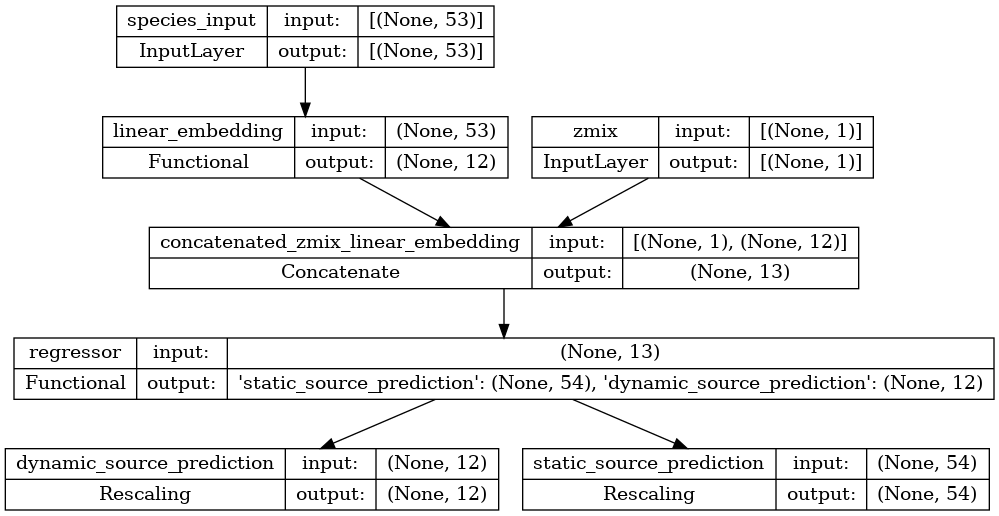

In [5]:
tf.keras.utils.plot_model(bestModel, show_shapes=True)

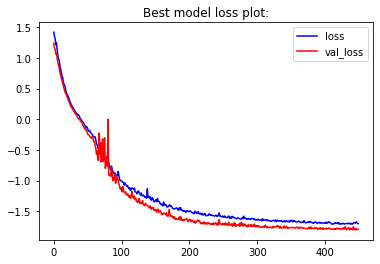

Best Model dev R^2 (combined):  0.8515233500441262
Best Model val static R^2: 0.850985586643219
Best Model val dynamic R^2: 0.9772778153419495


In [6]:
import matplotlib.pyplot as plt
plt.plot(experimentSettings['history']['loss'][50:], color='blue')
plt.plot(experimentSettings['history']['val_loss'][50:], color='red')
plt.legend(labels=['loss', 'val_loss'])
plt.title('Best model loss plot:')
plt.show()

# Legacy compatibility
if 'emb_and_regression_model_R2' in experimentSettings['val_losses']:
    experimentSettings['val_losses']['static_source_prediction_R2'] = experimentSettings['val_losses']['emb_and_regression_model_R2']

print('Best Model dev R^2 (combined): ', experimentSettings['model_R2'])
print('Best Model val static R^2:', experimentSettings['val_losses']['static_source_prediction_R2'])
print('Best Model val dynamic R^2:', experimentSettings['val_losses']['dynamic_source_prediction_R2_split'])

In [7]:
[col for col in dm.df.columns if col.startswith('Yi')]

['YiCH4',
 'YiH',
 'YiO',
 'YiO2',
 'YiOH',
 'YiH2O',
 'YiHO2',
 'YiH2O2',
 'YiC',
 'YiCH',
 'YiCH2',
 'YiCH2(S)',
 'YiCH3',
 'YiH2',
 'YiCO',
 'YiCO2',
 'YiHCO',
 'YiCH2O',
 'YiCH2OH',
 'YiCH3O',
 'YiCH3OH',
 'YiC2H',
 'YiC2H2',
 'YiC2H3',
 'YiC2H4',
 'YiC2H5',
 'YiC2H6',
 'YiHCCO',
 'YiCH2CO',
 'YiHCCOH',
 'YiN',
 'YiNH',
 'YiNH2',
 'YiNH3',
 'YiNNH',
 'YiNO',
 'YiNO2',
 'YiN2O',
 'YiHNO',
 'YiCN',
 'YiHCN',
 'YiH2CN',
 'YiHCNN',
 'YiHCNO',
 'YiHOCN',
 'YiHNCO',
 'YiNCO',
 'YiC3H7',
 'YiC3H8',
 'YiCH2CHO',
 'YiCH3CHO',
 'YiN2',
 'YiAR']

175/175 [==============================] - 0s 3ms/step
cpv6; 2.002709e+00 +/- 1.458756e-02
zmix; 1.615266e+00 +/- 2.043285e-02
cpv10; 9.732577e-01 +/- 7.698124e-03
cpv9; 3.434313e-01 +/- 1.055594e-02
cpv12; 2.178555e-01 +/- 3.934123e-03
cpv2; 1.460388e-01 +/- 6.422248e-03
cpv5; 1.257751e-01 +/- 5.870179e-03
cpv4; 8.489404e-02 +/- 4.679747e-03
cpv1; 6.498124e-02 +/- 3.549622e-03
cpv11; 5.569297e-02 +/- 2.966509e-03
cpv7; 4.817153e-02 +/- 8.670173e-04
cpv8; 2.287183e-02 +/- 8.561005e-04
cpv3; 1.934299e-02 +/- 1.047657e-03


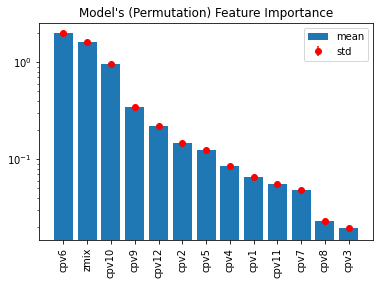

In [8]:
n_repeats = 5 if debug_mode else 20
inspector.plot_permutation_feature_importance(n_repeats=n_repeats)

         zmix      cpv1      cpv2      cpv3      cpv4      cpv5      cpv6  \
min  0.000000  0.000000  0.000037  0.000013  0.000018  0.002983  0.000017   
25%  0.232348  0.002396  0.002567  0.001454  0.002129  0.003997  0.055461   
50%  0.422880  0.007239  0.008016  0.004673  0.006499  0.006046  0.078167   
75%  0.649733  0.011529  0.013812  0.007857  0.011376  0.014832  0.084835   
max  0.974047  0.014110  0.017135  0.009715  0.014225  0.033651  0.090038   

         cpv7      cpv8      cpv9     cpv10     cpv11     cpv12  
min  0.004304  0.002557  0.000824  0.000002  0.000027  0.008469  
25%  0.005504  0.003646  0.006693  0.030170  0.001700  0.010744  
50%  0.008858  0.006391  0.011384  0.050438  0.005672  0.018404  
75%  0.017594  0.011341  0.018552  0.061698  0.010302  0.032086  
max  0.036630  0.020981  0.022615  0.117921  0.012906  0.046198  
1/1 [==============================] - 0s 13ms/step


/home/dwyerdei/.conda/envs/rom-project/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


1/1 [==============================] - 0s 13ms/step


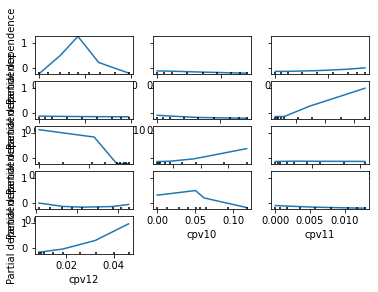

In [9]:
inspector.plot_partial_dependence()

#### Error Density by FlameId & XPos

584/584 [==============================] - 2s 3ms/step


Text(0.5, 1.0, 'Residual, Marginal Density plot:')

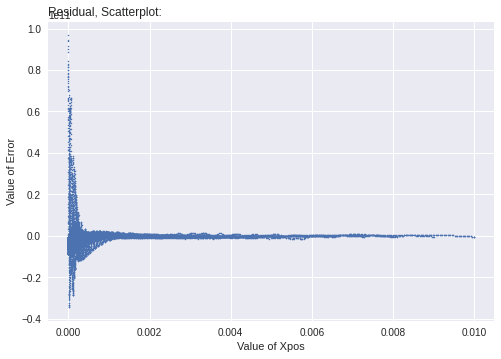

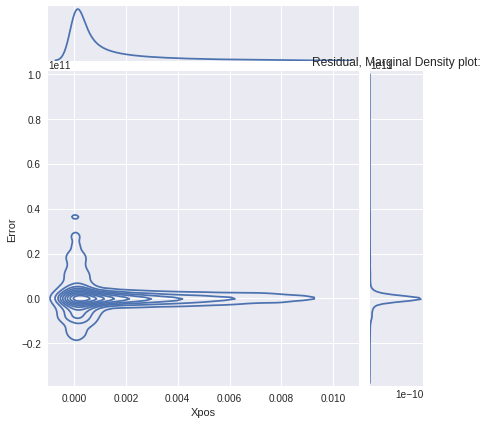

In [10]:
def getResiduals(Y,Y_pred):
    return Y-Y_pred

# TODO: Sanity check that this plots output ranges are correct? Seems like bug!
bestModel = exprExec.modelFactory.getEmbRegressor()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# libraries and data
plt.style.use('seaborn')

opscaler = dm.outputScaler
df = dp.getDataframe()
X, Y, Zmix, sources = dm.getAllData()
Y_pred = bestModel.predict({"species_input":X, "zmix":Zmix})['static_source_prediction']

# TODO: check should there be inverse transform here?
souener_pred = opscaler.inverse_transform(Y_pred)[:, dm.souener_index]
souener_actual = opscaler.inverse_transform(Y)[:, dm.souener_index]

#residual/error
residuals = getResiduals(souener_actual,souener_pred)
Xpos = df['Xpos']

plt_df = pd.DataFrame()
plt_df["Xpos"] = Xpos
plt_df["Error"] = residuals
# plot
plt.plot('Xpos', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Xpos')
plt.ylabel('Value of Error')
plt.title('Residual, Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Xpos, y=plt_df.Error, kind='kde')
plt.title('Residual, Marginal Density plot:')

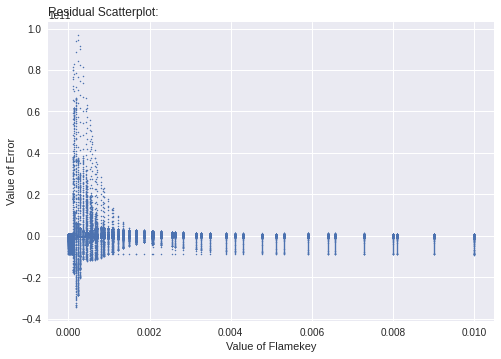

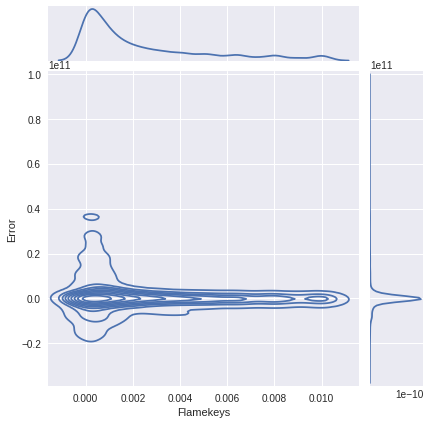

In [11]:
flamekeys = df['flame_key']

plt_df = pd.DataFrame()
plt_df["Flamekeys"] = flamekeys
plt_df["Error"] = residuals
# plot
plt.plot( 'Flamekeys', 'Error', data=plt_df, linestyle='', marker='o',markersize=1.5)
plt.xlabel('Value of Flamekey')
plt.ylabel('Value of Error')
plt.title('Residual Scatterplot:', loc='left')

# 2D density + marginal distribution:
sns.jointplot(x=plt_df.Flamekeys, y=plt_df.Error, kind='kde')

Text(0.5, 1.0, 'Souener (scaled) histogram')

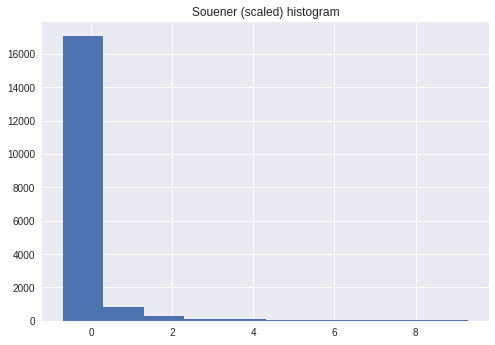

In [12]:
plt.hist(Y[:,0])
plt.title('Souener (scaled) histogram')

Text(0.5, 1.0, 'Souener_pred (scaled) histogram')

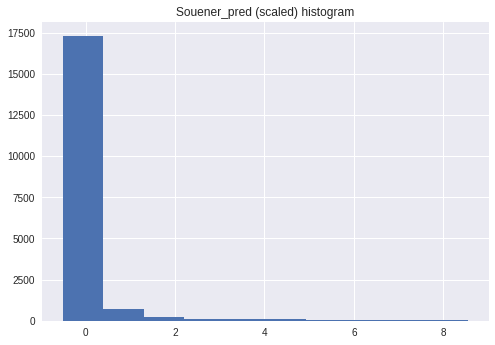

In [13]:
plt.hist(Y_pred[:,0])
plt.title('Souener_pred (scaled) histogram')